In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging

import holoviews as hv
import hvplot.polars  # noqa
import polars as pl
import numpy as np
from src.data.database_manager import DatabaseManager
from src.experiments.measurement.stimulus_generator import StimulusGenerator
from src.features.labels import process_labels
from src.features.scaling import scale_min_max
from src.features.transforming import map_trials, merge_dfs
from src.log_config import configure_logging
from src.plots.plot_modality import plot_modality_over_trials
from src.plots.plot_stimulus import plot_stimulus_with_shapes

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()

In [4]:
stim = StimulusGenerator(seed=396)
plot_stimulus_with_shapes(stim)

In [5]:
with db:
    stimulus = db.get_table("Feature_Stimulus")
    trials = db.get_table("Trials")
df = merge_dfs(
    dfs=[stimulus, trials], on=["trial_id", "participant_id", "trial_number"]
)
df = process_labels(df)

In [6]:
df.describe().filter(pl.col("statistic") == "max").select(pl.col("^.*_intervals$"))

decreasing_intervals,major_decreasing_intervals,increasing_intervals,plateau_intervals,prolonged_minima_intervals
f64,f64,f64,f64,f64
1660.0,996.0,1659.0,664.0,332.0


In [7]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=[
        "decreasing_intervals",
        "major_decreasing_intervals",
        "increasing_intervals",
        "plateau_intervals",
        "prolonged_minima_intervals",
    ],
    groupby="trial_id",
)  # * plot_modality_over_trials("Stimulus")

BokehModel(combine_events=True, render_bundle={'docs_json': {'dbf2903c-6d25-4b1f-8ec5-30ceb335aef9': {'version…

In [8]:
trial_id = 6
seed = df.filter(pl.col("trial_id") == trial_id)["stimulus_seed"].unique().item()
stim = StimulusGenerator(seed=seed)
plot_stimulus_with_shapes(stim)

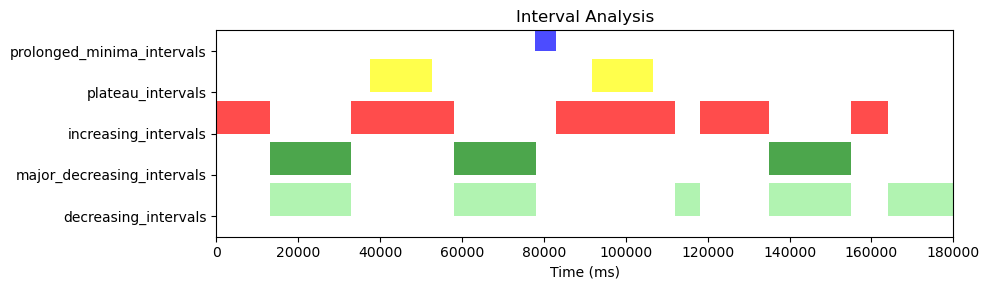

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

labels = stim.labels


# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 3))

# Define colors for each type of interval
labels = stim.labels
colors = dict(zip(labels.keys(), ["lightgreen", "green", "red", "yellow", "blue"]))


# Plot patches for each interval type
num_types = len(labels)
for i, (interval_type, intervals) in enumerate(labels.items()):
    for start, end in intervals:
        ax.add_patch(
            patches.Rectangle(
                (start, i),
                end - start,
                0.8,
                facecolor=colors[interval_type],
                edgecolor="none",
                alpha=0.7,
            )
        )

# Set axis limits and labels
ax.set_xlim(0, stim.duration * 1000)
ax.set_ylim(-0.5, num_types - 0.5)
ax.set_xlabel("Time (ms)")
ax.set_yticks(range(num_types))
ax.set_yticklabels(labels.keys())

# Add legend
legend_elements = [
    patches.Patch(facecolor=color, edgecolor="none", alpha=0.7, label=label)
    for label, color in colors.items()
]

# Set title
plt.title("Interval Analysis")

# Show plot
plt.tight_layout()


In [13]:
stim.increasing_intervals_idx, stim.decreasing_intervals_idx

([(0, 130), (330, 580), (829, 1120), (1180, 1350), (1550, 1640)],
 [(130, 330), (580, 780), (1120, 1180), (1350, 1550), (1640, 1800)])

In [14]:
stim.labels

{'decreasing_intervals': [(13000, 33000),
  (58000, 78000),
  (112000, 118000),
  (135000, 155000),
  (164000, 180000)],
 'major_decreasing_intervals': [(13000, 33000),
  (58000, 78000),
  (135000, 155000)],
 'increasing_intervals': [(0, 13000),
  (33000, 58000),
  (82900, 112000),
  (118000, 135000),
  (155000, 164000)],
 'plateau_intervals': [(37600, 52600), (91700, 106700)],
 'prolonged_minima_intervals': [(77900, 82900)]}

In [11]:
                        if start > stim.decreasing_intervals_idx[idx // 2][0]:
                            print("ERROR")

NameError: name 'idx' is not defined

In [9]:
raz hpc facilities

SyntaxError: invalid syntax (2840712464.py, line 1)

-> start with the easiest problem: first 5 s of increases vs first 5 s of decreases

from Wang et al. (2024):

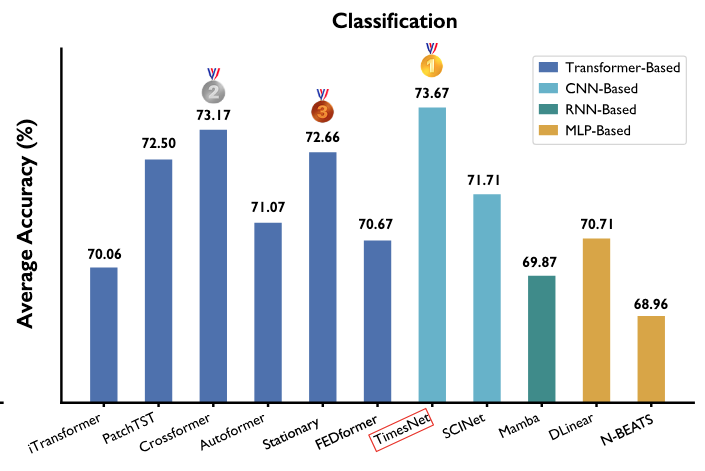

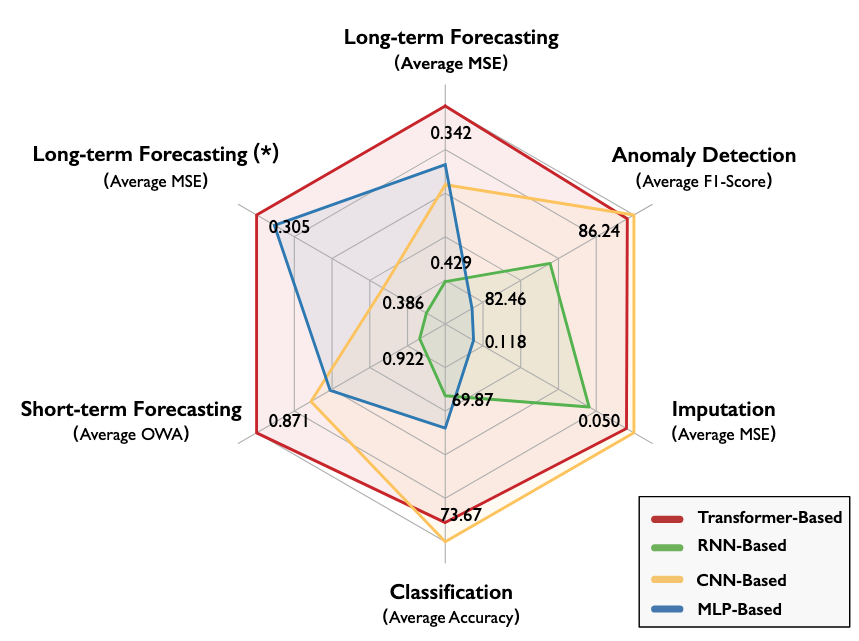